# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [77]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json

# Import API key
from api_keys import g_key

# Configure gmaps
gmaps.configure(api_key=g_key)


### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [80]:
# Importing csv file from Part 1 WeatherPy
weather_df = pd.read_csv("../output_data/cities_data.csv")
weather_df



,City_ID,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temperature,Wind Speed
0,1,dikson,94,RU,1635650805,90,73.5069,80.5464,6.19,15.08
1,2,albany,100,US,1635650767,97,42.6001,-73.9662,55.35,3.20
2,3,ucluelet,2,CA,1635650806,60,48.9329,-125.5528,39.96,6.78
3,4,rabo de peixe,100,PT,1635650806,94,37.8000,-25.5833,69.60,15.50
4,5,baghdad,20,IQ,1635650654,68,33.3406,44.4009,73.31,6.91
...,...,...,...,...,...,...,...,...,...,...
553,554,apud,52,PH,1635651004,56,13.1393,123.2916,86.77,4.21
554,555,carrollton,1,US,1635650983,43,32.9537,-96.8903,64.11,4.61
555,556,chakwal,0,PK,1635651005,28,32.9334,72.8585,70.56,3.60
556,557,pinhao,100,BR,1635651006,97,-25.6956,-51.6597,59.29,6.51


In [81]:
weather_df = weather_df.dropna(how='any')
len(weather_df)

551

### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [82]:
locations = weather_df[["Latitude", "Longitude"]]
weight = weather_df["Humidity"].astype(float)

In [83]:
# Plot Heatmap

fig = gmaps.figure(map_type = "TERRAIN", center = (0, 0), zoom_level = 1.5)


# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=weight, 
                                 dissipating=False, max_intensity=20,
                                 point_radius=1)

# Add layer
fig.add_layer(heat_layer)


# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

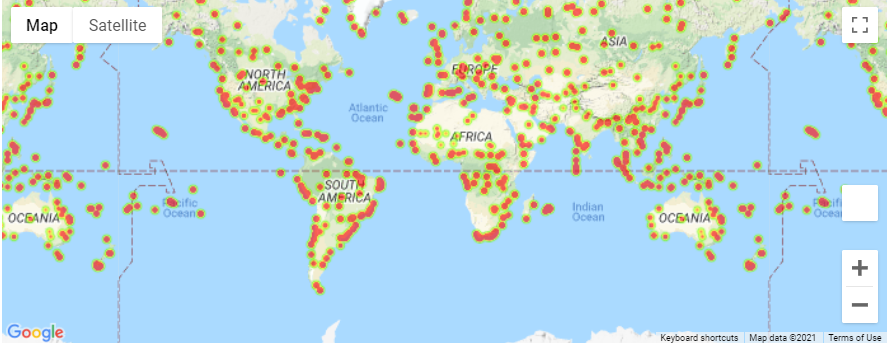

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

## Ideal Condition.
* A max temperature lower than 80 degrees but higher than 75.
* Wind speed less than 5 mph.
* Zero cloudiness.
* Drop any rows that don't contain all three conditions. You want to be sure the weather is ideal.


In [93]:
ideal_weather_df = weather_df.loc[(weather_df["Max Temperature"]<80)\
                                  & (weather_df["Max Temperature"] >75)\
                                  & (weather_df["Wind Speed"]<5)&(weather_df["Cloudiness"]==0)]
ideal_weather_df


,City_ID,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temperature,Wind Speed
254,255,dakar,0,SN,1635650847,83,14.6937,-17.4441,78.93,0.00
294,295,poum,0,NC,1635650403,71,-20.2333,164.0167,76.35,3.00
380,381,abu dhabi,0,AE,1635650811,73,24.4667,54.3667,78.82,4.61
430,431,hermosillo,0,MX,1635650764,37,29.0667,-110.9667,79.38,1.01


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [106]:
city_name = []
country = []
hotel_name = []
hotel_lat = []
hotel_lng = []

for i in range(len(ideal_weather_df)):
    try:
        target_coordinates = f"{ideal_weather_df.iloc[i,6]},{ideal_weather_df.iloc[i,7]}"
        target_search = "Hotel"
        target_radius = 5000
        target_type = "hotel"

        base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

        params = {
        "location": target_coordinates,
        "keyword": target_search,
        "radius": target_radius,
        "type": target_type,
        "key": g_key
        }

        response = requests.get(base_url, params=params)
        places_data = response.json()

#         print(response.url)

        #storing hotel information
        hotel_name.append(places_data["results"][0]["name"])
        hotel_lat.append(places_data["results"][0]["geometry"]["location"]["lat"])
        hotel_lng.append(places_data["results"][0]["geometry"]["location"]["lng"])
        country.append(ideal_weather_df.iloc[i,3])
        city_name.append(ideal_weather_df.iloc[i,1])
    except:
        print(f"No hotels found in {ideal_weather_df.iloc[i,1]} within the radius")
        

No hotels found in poum within the radius


In [107]:
hotel_data = {
    "City" : city_name,
    "Country":country,
    "Hotel Name" : hotel_name,
    "Lat": hotel_lat,
    "Lng": hotel_lng,
    }

hotel_df = pd.DataFrame(hotel_data)
hotel_df

,City,Country,Hotel Name,Lat,Lng
0,dakar,SN,"Radisson Blu Hotel, Dakar Sea Plaza",14.694667,-17.473058
1,abu dhabi,AE,Emirates Palace,24.461644,54.317283
2,hermosillo,MX,Hampton Inn by Hilton Hermosillo,29.069351,-110.951579


In [126]:
# NOTE: Do not change any of the code in this cell

Name = hotel_df["Hotel Name"]
City = hotel_df["City"]
Country = hotel_df["Country"]

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

In [129]:
# Assign the marker layer to a variable

markers = gmaps.marker_layer(locations, info_box_content=hotel_info)
# Add the layer to the map

fig = gmaps.figure(map_type = "TERRAIN", center = (0, 0), zoom_level = 1.5)
fig.add_layer(markers)

fig

Figure(layout=FigureLayout(height='420px'))

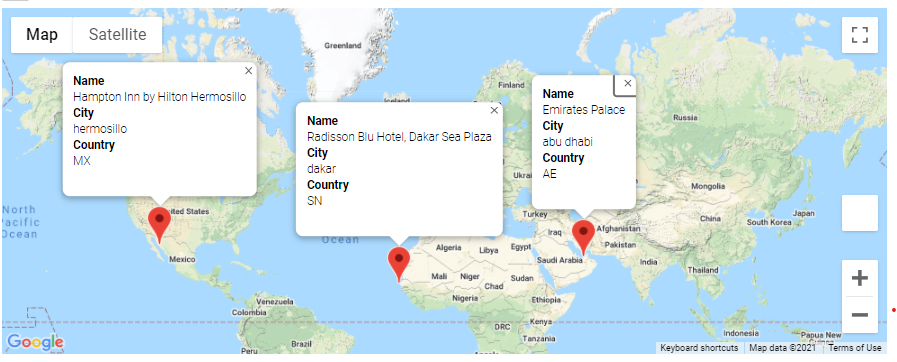

In [125]:
# Add marker layer ontop of heat map
fig.add_layer (heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

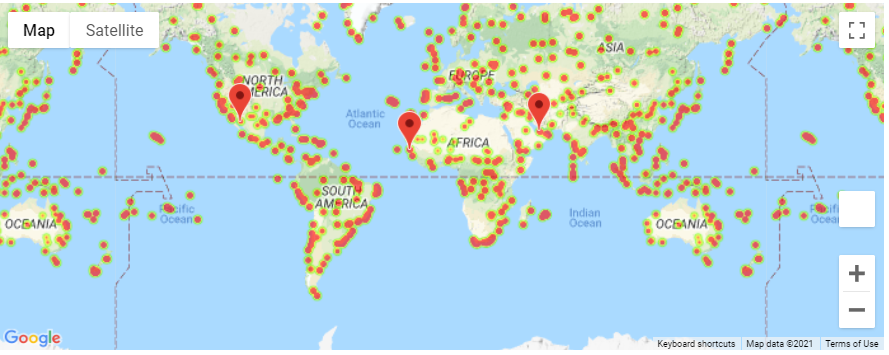